# Putting the pieces together

This notebook focuses on integrating what we have learned so far. It leverages a library (`comms`) of the functions that we have developed in our notebooks so far. This library is located in <a href="https://github.com/bepepa/digital_comms/tree/main/comms">our Github</a> archive.

We illustrate how to use this library by constructing a transmitter and receiver. We describe both of these as a Python class so that properties, like constellation and pulse shape, are encapsulated. Our example, assumes the following parameters:

* pulse shaping: square-root raised cosine pulse with roll-off factor $\beta = 0.5$
* constellation: QPSK
* oversampling by `fsT`=8

<a href="https://colab.research.google.com/github/bepepa/digital_comms/blob/master/030_pulse_shaping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> (Executable notebook)

<a href="https://nbviewer.org/format/slides/github/bepepa/digital_comms/blob/main/030_pulse_shaping.ipynb"><img src="https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg" alt="Render nbviewer" /> </a> (read-only, slides view)

In [11]:
## Boilerplate instructions for importing NumPy and Matplotlib
# Import NumPy
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns_context = "notebook"
sns.set_theme(context=sns_context, style="ticks")

# proper labeling of plots
from matplotlib.ticker import EngFormatter

## Importing what we need

To use the functions from the library, we need to import them. This obviates the need to copy and paste definitions of these functions into the notebook.



In [12]:
# import our functions
from comms.mod_mapping import QAM16, QPSK, mod_mapper, demodulator, normalize_Eb
from comms.pulse_shaping import srrc_pulse, pulse_shape, half_sine_pulse
from comms.sources import string_sink, string_source
from comms.utils import Q

## Set Parameters

For our simple example, we use the following signal parameters

* `fsT = 8`: number of samples per symbol period
* `beta = 0.5`: roll-off factor for SRRC pulse
* `constellation = normalize_Eb(QPSK)`: QPSK, normalized such that energy per bit is 1
* `pulse = srrc_pulse(beta, fsT)`: SRRC pulse, normalized so that $\sum_n |p[n]|^2 = 1$, pulse is truncated at $\pm 5$ the default value).

Note, scaling of the constellation impacts if simulation results are in terms of $E_b/N_0$ or $E_s/N_0$.

In [13]:
## Parameters
beta = 0.5
fsT = 8

# make sure, constellation is scaled to have unit energy
qpsk = normalize_Eb(QPSK)    
# pulse is scaled such that sum |p[n]|**2 = 1
pulse = srrc_pulse(beta, fsT)


## Defining the Transmitter

It is convenient (but not necessary) to encapsulate the parameters and the necessary signal processing into an object. This ties together the configuration of the system and its operation.


In [14]:
class Transmitter():
    """A class that describes a digital transmitter performing linear modulation"""

    def __init__(self, constellation, fsT, pulse_shape):
        """set transmitter parameters"""

        self.fsT = fsT
        self.pulse_shape = pulse_shape
        self.constellation = constellation

    def __call__(self, bits):
        """convert a sequence of bits into a modulated signal"""
        syms = mod_mapper(bits, self.constellation)
        return pulse_shape(syms, self.pulse_shape, self.fsT)

When defined as above, a transmitter is instantiated by specifying parameters `constellation`, `fsT`, and `pulse`.

In [15]:
# instantiate a transmitter
tx = Transmitter(constellation=qpsk,
                 fsT=fsT,
                 pulse_shape=pulse)

And, it is invoked by passing a sequence of bits to modulate. 

In the cell below, a sequence of bits is generated from a string. This sequence is passed to the transmitter object `tx`; this invokes the `__call__()` function in the definition of `Transmitter`. The output from that function are samples of the signal to be transmitted.

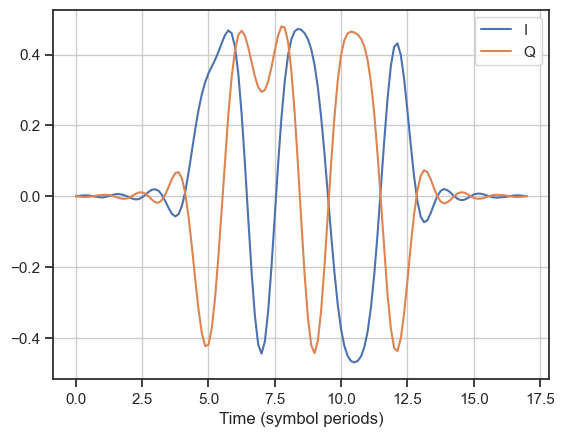

In [16]:
# generating the transmitted signal is 
bits = string_source('Hi')
tx_sig = tx(bits)

# plot signal
tt = np.arange(len(tx_sig)) / fsT
plt.plot(tt, np.real(tx_sig), label='I')
plt.plot(tt, np.imag(tx_sig), label='Q')
plt.grid()
plt.xlabel('Time (symbol periods)')
plt.legend()
plt.show()

## Defining the Receiver

To define the receiver, we proceed similarly. We create a `Receiver` class that encapsulates configuration parameters and functions.

In [17]:
class Receiver():
    """A class that describes a digital receiver performing linear modulation"""

    def __init__(self, constellation, fsT, pulse_shape):
        """set transmitter parameters"""

        self.fsT = fsT
        self.pulse_shape = pulse_shape
        self.constellation = constellation

        self.d_samples = len(self.pulse_shape) - 1

    def __call__(self, sig, n_bits=None):
        """convert a received signal into a sequence of bits """
        # matched filter
        mf_out = self.matched_filter(sig)

        # down-sample the matched filter to obtain symbol estimates
        syms = mf_out[self.d_samples::fsT]

        # recover bits
        bits = demodulator(syms, self.constellation, n_bits)

        return  bits
        
    def matched_filter(self, sig):
        """matched filter the received signal"""

        return np.convolve(sig, np.flip(self.pulse_shape))

The cell below puts the receiver to use.

In [18]:
# instantiate the transmitter
rx = Receiver(qpsk, fsT, pulse)

# and invoke it
rx_bits = rx(tx_sig, len(bits))

# see what we got
string_sink(rx_bits)

'Hi'

If desired, we can still get the matched filter output from the receiver. If the symbol estimates (down-sampled matched filter outputs are needed), another method is added to the class.

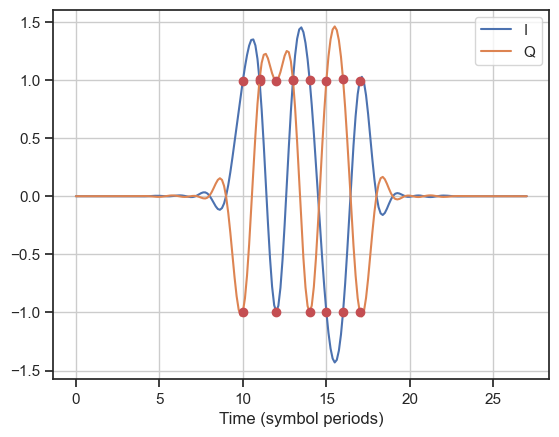

In [19]:
mf_out = rx.matched_filter(tx_sig)

# plot signal
tt = np.arange(len(mf_out)) / fsT
# mark the symbol locations
dd = len(pulse) - 1
ind = np.arange(len(mf_out))[dd::fsT][:8]

plt.plot(tt, np.real(mf_out), label='I')
plt.plot(tt[ind], np.real(mf_out[ind]), 'ro')
plt.plot(tt, np.imag(mf_out), label='Q')
plt.plot(tt[ind], np.imag(mf_out[ind]), 'ro')
plt.grid()
plt.xlabel('Time (symbol periods)')
plt.legend()
plt.show()

## Payoff: much shorter simulation code

A complete simulation might look like this.

In [10]:
tx = Transmitter(qpsk, fsT, pulse)
rx = Receiver(qpsk, fsT, pulse)

SNR_dB = 10
SNR = 10**(SNR_dB/10)
bits_per_frame = 200

n_bits = 0
n_errors = 0

while n_errors < 400 and n_bits < 1e6:
    bits = np.random.randint(2, size=bits_per_frame)
    tx_sig = tx(bits)

    rx_sig = (tx_sig + 
              np.sqrt(1/SNR) * (np.random.randn(len(tx_sig)) + 
                                      1j*np.random.randn(len(tx_sig))))
    
    rx_bits = rx(rx_sig, bits_per_frame)

    n_bits += bits_per_frame
    n_errors += np.sum(bits ^ rx_bits)

print("Found {:d} errors in {:d} bits; estimated bit error rate {:8.6f}".format(n_errors, n_bits, n_errors/n_bits))
print(f"The exact value for the bit error rate is: {Q(np.sqrt(SNR)):8.6f}")

Found 400 errors in 499800 bits; estimated bit error rate 0.000800
The exact value for the bit error rate is: 0.000783
